In [1]:
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets

import args
import utils
from networks import LossNetwork, StyleBankNet

"""********Important*******"""
args.continue_training = True # change to your setting
"""************************"""

device = args.device

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg-cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [2]:
cat args.py

import torch
import os

device = torch.device("cuda")

batch_size = 5
lr = 0.001
T = 2
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1000000
REG_WEIGHT = 1e-5

continue_training = True

CONTENT_IMG_DIR = 'test/content'
STYLE_IMG_DIR = 'test/style'
MODEL_WEIGHT_DIR = 'weights_step'
BANK_WEIGHT_DIR = os.path.join(MODEL_WEIGHT_DIR, 'bank')
BANK_WEIGHT_PATH = os.path.join(BANK_WEIGHT_DIR, '{}.pth')
MODEL_WEIGHT_PATH = os.path.join(MODEL_WEIGHT_DIR, 'model.pth')
ENCODER_WEIGHT_PATH = os.path.join(MODEL_WEIGHT_DIR, 'encoder.pth')
DECODER_WEIGHT_PATH = os.path.join(MODEL_WEIGHT_DIR, 'decoder.pth')
GLOBAL_STEP_PATH = os.path.join(MODEL_WEIGHT_DIR, 'global_step.log')

K = 1000
MAX_ITERATION = 300 * K
SAVE_MODEL_POINT = 10 * K
ADJUST_LR_ITER = 10 * K
LOG_ITER = 1 * K

In [3]:
!rm -rf test/style/.ipynb_checkpoints/

In [4]:
os.listdir('test/style')

['git_style']

# Dataset

In [5]:
"""
Load Dataset
"""
content_dataset = datasets.ImageFolder(root=args.CONTENT_IMG_DIR, transform=utils.content_img_transform)
content_dataloader = torch.utils.data.DataLoader(content_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)

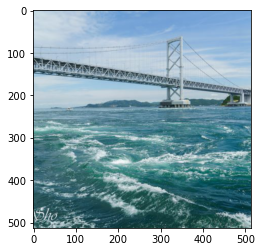

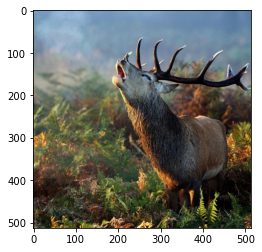

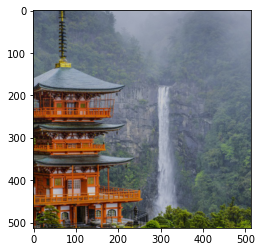

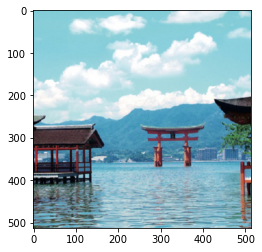

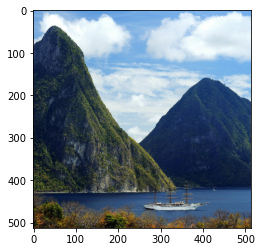

In [6]:
"""
Display content images
"""
from torchvision.utils import save_image
for imgs, _ in content_dataloader:
    for i in range(args.batch_size):
        utils.showimg(imgs[i])
        #save_image(imgs[i], "fixed_image/image_"+str(i)+".png")
    break

In [7]:
"""
Load Style Dataset
"""
style_dataset = datasets.ImageFolder(root=args.STYLE_IMG_DIR, transform=utils.style_img_transform)
style_dataset = torch.cat([img[0].unsqueeze(0) for img in style_dataset], dim=0)
style_dataset = style_dataset.to(device)

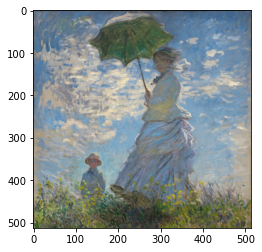

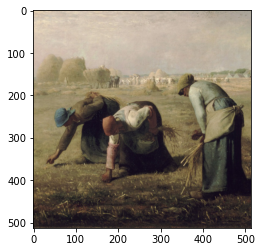

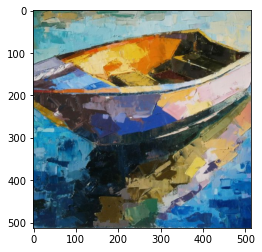

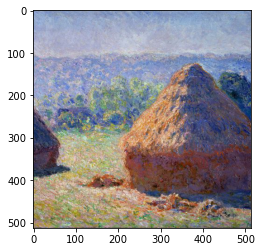

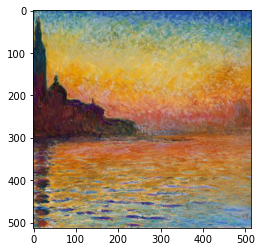

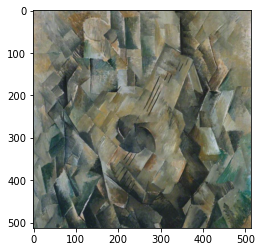

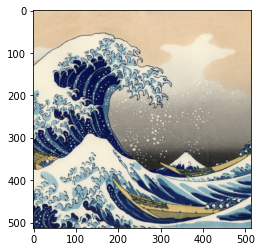

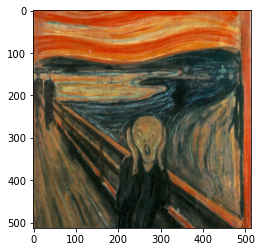

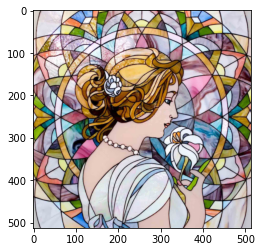

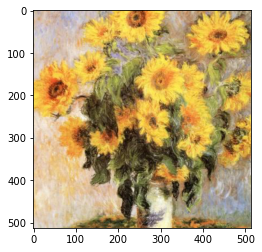

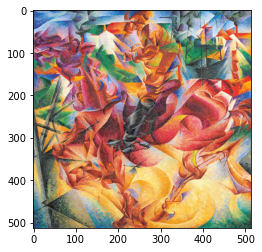

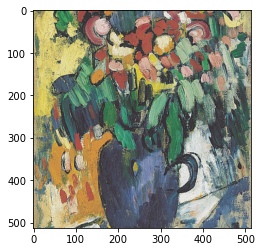

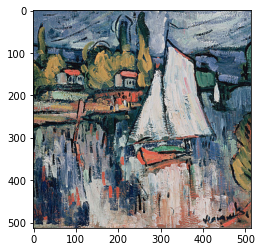

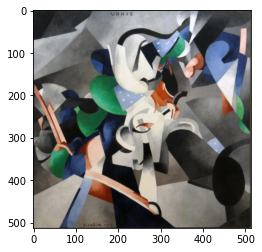

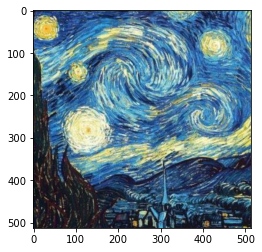

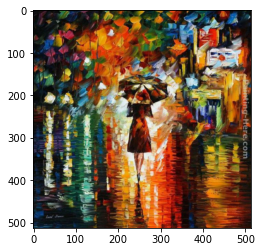

In [8]:
"""
Display style images
"""
for img in style_dataset:
    utils.showimg(img)

# Load Model & Network

In [9]:
"""
Define Model and Loss Network (vgg16)
"""
model = StyleBankNet(len(style_dataset)).to(device)

if args.continue_training:
    if os.path.exists(args.GLOBAL_STEP_PATH):
        with open(args.GLOBAL_STEP_PATH, 'r') as f:
            global_step = int(f.read())
    else:
        raise Exception('cannot find global step file')
    if os.path.exists(args.MODEL_WEIGHT_PATH):
        model.load_state_dict(torch.load(args.MODEL_WEIGHT_PATH))
    else:
        raise Exception('cannot find model weights')
else:
    if not os.path.exists(args.MODEL_WEIGHT_DIR):
        os.mkdir(args.MODEL_WEIGHT_DIR)
    if not os.path.exists(args.BANK_WEIGHT_DIR):
        os.mkdir(args.BANK_WEIGHT_DIR)
    global_step = 0
        
optimizer = optim.Adam(model.parameters(), lr=args.lr)
optimizer_ae = optim.Adam(model.parameters(), lr=args.lr)
loss_network = LossNetwork().to(device)

/home/z7wei/Stylebank/networks.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/home/z7wei/Stylebank/networks.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


# Training

In [ ]:
"""
Training
"""

# [0, 1, 2, ..., N]
style_id = list(range(len(style_dataset)))
style_id_idx = 0
style_id_seg = []
for i in range(0, len(style_dataset), args.batch_size):
    style_id_seg.append(style_id[i:i+args.batch_size])
    
s_sum = 0 # sum of style loss
c_sum = 0 # sum of content loss
l_sum = 0 # sum of style+content loss
r_sum = 0 # sum of reconstruction loss
tv_sum = 0 # sum of tv loss

while global_step <= args.MAX_ITERATION:
    for i, data in enumerate(content_dataloader):
        global_step += 1
        data = data[0].to(device)
        batch_size = data.shape[0]
        if global_step % (args.T+1) != 0:
            style_id_idx += 1
            sid = utils.get_sid_batch(style_id_seg[style_id_idx % len(style_id_seg)], batch_size)
            
            optimizer.zero_grad()
            output_image = model(data, sid)
            content_score, style_score = loss_network(output_image, data, style_dataset[sid])
            content_loss = args.CONTENT_WEIGHT * content_score
            style_loss = args.STYLE_WEIGHT * style_score
            
            diff_i = torch.sum(torch.abs(output_image[:, :, :, 1:] - output_image[:, :, :, :-1]))
            diff_j = torch.sum(torch.abs(output_image[:, :, 1:, :] - output_image[:, :, :-1, :]))
            tv_loss = args.REG_WEIGHT*(diff_i + diff_j)
            
            total_loss = content_loss + style_loss + tv_loss
            total_loss.backward()
            optimizer.step()

            l_sum += total_loss.item()
            s_sum += style_loss.item()
            c_sum += content_loss.item()
            tv_sum += tv_loss.item()

        if global_step % (args.T+1) == 0:
            optimizer_ae.zero_grad()
            output_image = model(data)
            loss = F.mse_loss(output_image, data)
            loss.backward()
            optimizer_ae.step()
            r_sum += loss.item()
            
        if global_step % 100 == 0:
            print('.', end='')
            
        if global_step % args.LOG_ITER == 0:
            print("gs: {} {} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f}".format(global_step / args.K, time.strftime("%H:%M:%S"), l_sum / 666, c_sum / 666, s_sum / 666, tv_sum / 666, r_sum / 333))
            r_sum = 0
            s_sum = 0
            c_sum = 0
            l_sum = 0
            tv_sum = 0
            # save whole model (including stylebank)
            torch.save(model.state_dict(), args.MODEL_WEIGHT_PATH)
            # save seperate part
            with open(args.GLOBAL_STEP_PATH, 'w') as f:
                f.write(str(global_step))
            torch.save(model.encoder_net.state_dict(), args.ENCODER_WEIGHT_PATH)
            torch.save(model.decoder_net.state_dict(), args.DECODER_WEIGHT_PATH)
            for i in range(len(style_dataset)):
                torch.save(model.style_bank[i].state_dict(), args.BANK_WEIGHT_PATH.format(i))
        
        if global_step % args.SAVE_MODEL_POINT == 0:
            # make directory
            step_dir = args.MODEL_WEIGHT_DIR + "/" + str(global_step)
            if not os.path.exists(step_dir):
                os.mkdir(step_dir)
            # save whole model (including stylebank)
            torch.save(model.state_dict(), os.path.join(step_dir, 'model.pth'))
            # save seperate part
#             with open(args.GLOBAL_STEP_PATH, 'w') as f:
#                 f.write(str(global_step))
            torch.save(model.encoder_net.state_dict(), os.path.join(step_dir, 'encoder.pth'))
            torch.save(model.decoder_net.state_dict(), os.path.join(step_dir, 'decoder.pth'))
            if not os.path.exists(step_dir + "/" + 'bank'):
                os.mkdir(step_dir + "/" + 'bank')
            for i in range(len(style_dataset)):
                torch.save(model.style_bank[i].state_dict(), os.path.join(step_dir + "/" + 'bank', '{}.pth'.format(i)))
            
        if global_step % args.ADJUST_LR_ITER == 0:
            lr_step = global_step / args.ADJUST_LR_ITER
            utils.adjust_learning_rate(optimizer, lr_step)
            new_lr = utils.adjust_learning_rate(optimizer_ae, lr_step)
            
            print("learning rate decay:", new_lr)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


..........gs: 87.0 13:46:01 97.437757 61.162892 33.153390 3.121475 0.000887
..........gs: 88.0 14:04:42 87.084845 57.611783 26.391436 3.081626 0.000759
..........gs: 89.0 14:23:13 99.930467 59.856566 36.943746 3.130154 0.000863
..........gs: 90.0 14:41:39 103.507854 61.014356 39.378233 3.115265 0.000907
learning rate decay: 0.00013421772800000008
..........gs: 91.0 15:00:28 75.804798 55.272845 17.490580 3.041372 0.000671
..........gs: 92.0 15:19:23 74.652793 54.690536 16.925465 3.036792 0.000664
..........gs: 93.0 15:38:08 73.436450 53.875522 16.533913 3.027015 0.000660
..........gs: 94.0 15:56:50 72.713636 53.475696 16.214953 3.022986 0.000652
..........gs: 95.0 16:15:10 71.572743 52.713699 15.840694 3.018350 0.000646
..........gs: 96.0 16:33:21 70.756051 52.176453 15.571919 3.007679 0.000643
..........gs: 97.0 16:51:39 70.065052 51.756766 15.306350 3.001936 0.000635
..........gs: 98.0 17:10:36 69.242388 51.225125 15.019553 2.997710 0.000628
........

# Inference

In [ ]:
model

In [ ]:
"""
Testing
"""
style_id = list(range(len(style_dataset)))
style_id_idx = 0
style_id_seg = []
for i in range(0, len(style_dataset), args.batch_size):
    style_id_seg.append(style_id[i:i+args.batch_size])

for i, data in enumerate(content_dataloader, 0):
    data = data[0].to(device)
    batch_size = data.shape[0]
#     data = data[0].repeat(batch_size, 1, 1, 1)
    for j in range(batch_size):
        utils.showimg(data[j].cpu())
    
    output_image = model(data)
    for j in range(batch_size):
        utils.showimg(output_image[j].cpu().detach())
    output_image = model(data, utils.get_sid_batch(style_id_seg[0], batch_size))
    for j in range(batch_size):
        utils.showimg(output_image[j].cpu().detach())
    break

In [26]:
!rm -rf ECE269/test_sample/.ipynb_checkpoints/

In [27]:
"""
Load Dataset
"""
test_dataset = datasets.ImageFolder(root="./ECE269/test_sample/", transform=utils.content_img_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)

In [30]:
model.load_state_dict(torch.load("weights_new/bank/0.pth"))

RuntimeError: Error(s) in loading state_dict for StyleBankNet:
	Missing key(s) in state_dict: "encoder_net.0.weight", "encoder_net.3.weight", "encoder_net.6.weight", "encoder_net.9.weight", "decoder_net.0.weight", "decoder_net.3.weight", "decoder_net.6.weight", "decoder_net.9.weight", "style_bank.0.0.weight", "style_bank.0.3.weight", "style_bank.1.0.weight", "style_bank.1.3.weight", "style_bank.2.0.weight", "style_bank.2.3.weight", "style_bank.3.0.weight", "style_bank.3.3.weight", "style_bank.4.0.weight", "style_bank.4.3.weight", "style_bank.5.0.weight", "style_bank.5.3.weight", "style_bank.6.0.weight", "style_bank.6.3.weight", "style_bank.7.0.weight", "style_bank.7.3.weight", "style_bank.8.0.weight", "style_bank.8.3.weight", "style_bank.9.0.weight", "style_bank.9.3.weight", "style_bank.10.0.weight", "style_bank.10.3.weight", "style_bank.11.0.weight", "style_bank.11.3.weight", "style_bank.12.0.weight", "style_bank.12.3.weight", "style_bank.13.0.weight", "style_bank.13.3.weight", "style_bank.14.0.weight", "style_bank.14.3.weight", "style_bank.15.0.weight", "style_bank.15.3.weight". 
	Unexpected key(s) in state_dict: "0.weight", "3.weight". 

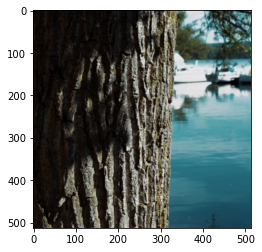

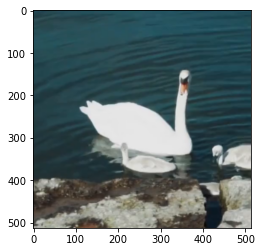

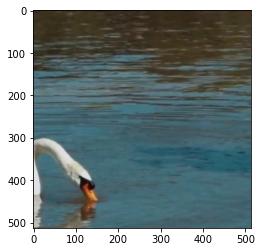

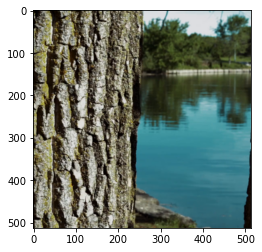

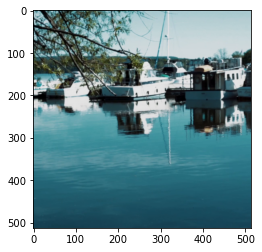

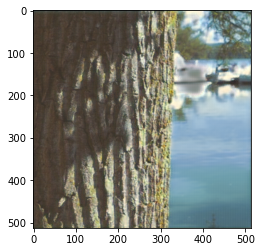

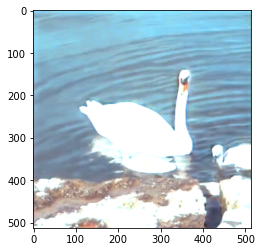

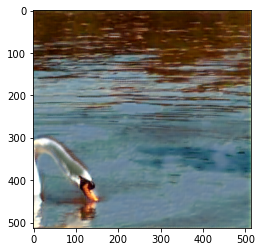

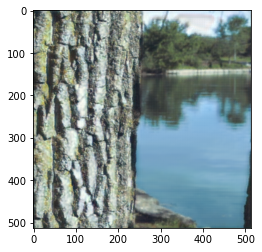

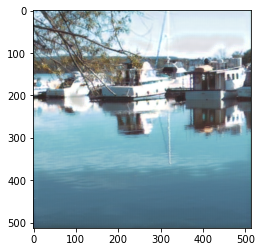

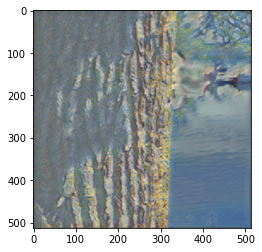

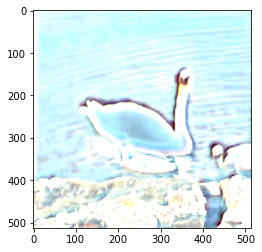

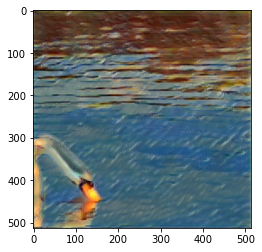

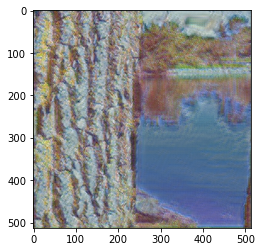

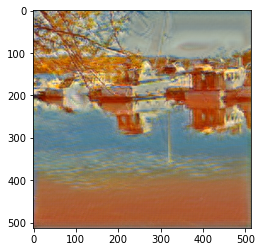

In [29]:
for i, data in enumerate(test_dataloader, 0):
    data = data[0].to(device)
    batch_size = data.shape[0]
#     data = data[0].repeat(batch_size, 1, 1, 1)
    for j in range(batch_size):
        utils.showimg(data[j].cpu())
    
    output_image = model(data)
    for j in range(batch_size):
        utils.showimg(output_image[j].cpu().detach())
    output_image = model(data, utils.get_sid_batch(style_id_seg[0], batch_size))
    for j in range(batch_size):
        utils.showimg(output_image[j].cpu().detach())
    break